### ISS VSE CA2 Part2

#### By: Kenneth Goh (A0198544N), Raymond Ng (A0198543R), Tan Heng Han (A0198502B)

In [1]:
import cv2
import os
import math
import time
from collections import Counter
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam

import sklearn.metrics as metrics

### Config

In [2]:
# Config
modelInWidth = 368
modelInHeight = 368
OPENPOSE_MODEL = 'coco'
TEST_SIZE = 0.2

### Load and slice videos for training
Slice training videos into 5hz frames for model input
Data set:
1. Push up videos
2. Mixture of non push up videos

In [4]:
# Get filenames and labels for data
labels = ['PushUps', 'NotPushUps']
data_path = 'data/'
files = pd.DataFrame()
filenames = []
for lbl in labels:
    filename = np.array(glob(os.path.join(data_path, lbl) + '/*.mp4'))
    filenames.append(filename)

files['video_name'] = [item for sublist in filenames for item in sublist]
files.head()

,video_name
0,data/PushUps\PushUps (1).mp4
1,data/PushUps\PushUps (10).mp4
2,data/PushUps\PushUps (2).mp4
3,data/PushUps\PushUps (3).mp4
4,data/PushUps\PushUps (4).mp4


In [12]:
# Slice and store the frames from training videos
for i in tqdm(range(files.shape[0])):
    count = 0
    videoFile = files['video_name'][i]
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % 2 == 0):
            # storing the frames in a new folder named train_1
            filename ='data/images/' + videoFile.split('\\')[1] +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.62s/it]


In [6]:
%%time
# Get filepath of all sliced images and read all images
dataset_frame_path = 'data/images'
frame_filenames = glob(dataset_frame_path + '/*.jpg')

frames_n_labels = pd.DataFrame()

frame_list = []
label_list = []
for idx in tqdm(range(len(frame_filenames))):
    frame_list.append(cv2.imread(frame_filenames[idx]))
    label = frame_filenames[idx].split('_')[1]
    if label not in labels:
        label = labels[0] # Assign all non-pushup (change to pushups for testing of counter script)
    label_list.append(label)
frames_n_labels['frame'] = frame_list
frames_n_labels['label'] = label_list
frames_n_labels.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 61.60it/s]


Wall time: 737 ms


,frame,label
0,"[[[19, 28, 32], [17, 26, 30], [15, 24, 28], [1...",PushUps
1,"[[[16, 25, 29], [14, 23, 27], [14, 23, 27], [1...",PushUps
2,"[[[18, 27, 36], [18, 27, 36], [19, 28, 37], [1...",PushUps
3,"[[[18, 27, 36], [18, 27, 36], [19, 28, 37], [1...",PushUps
4,"[[[18, 27, 36], [18, 27, 36], [19, 28, 37], [1...",PushUps


Text(0.5,1,'Frame Distribution')

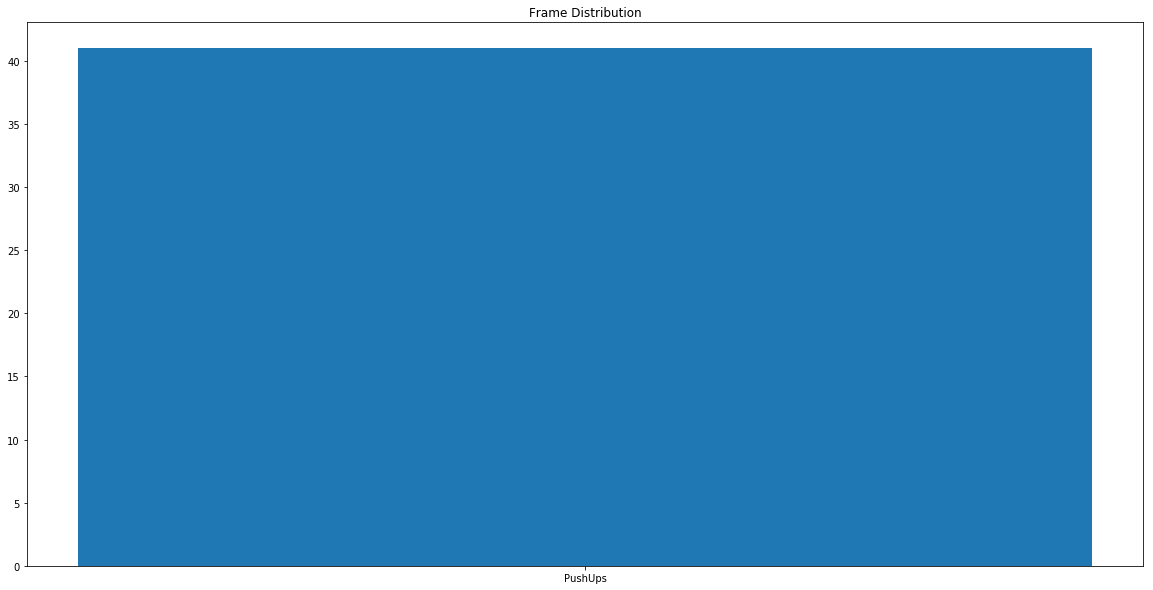

In [7]:
label_count = Counter(frames_n_labels['label'])
plt.figure(figsize=(20,10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Frame Distribution')

In [17]:
# Train test split
# trainData, testData, trainLabel, testLabel = train_test_split(final_train['frame'], final_train['label'], test_size=TEST_SIZE, random_state=42)

In [18]:
# print(f'trainData shape: {trainData.shape}')
# print(f'testData shape: {testData.shape}')
# print(f'trainLabel shape: {trainLabel.shape}')
# print(f'testLabel shape: {testLabel.shape}')

### Load OpenPose models

#### Instructions to get openpose models
1. Clone https://github.com/CMU-Perceptual-Computing-Lab/openpose
2. Open a console and run **openpose/models/getModels.bat**
3. Copy contents from **openpose/models/pose/mpi to Model/mpi** and **openpose/models/pose/coco to Model/coco**

In [8]:
if OPENPOSE_MODEL == 'coco':
    PROTO_FILE = 'Model/pose_deploy_linevec.prototxt'
    WEIGHTS_FILE = 'Model/pose_iter_440000.caffemodel'
elif OPENPOSE_MODEL == 'mpi':
    PROTO_FILE = 'Model/mpi/pose_deploy_linevec_faster_4_stages.prototxt'
    WEIGHTS_FILE = 'Model/mpi/pose_iter_160000.caffemodel'
else:
    raise Exception('Open pose model not recognised, choose either mpi or coco')

In [9]:
if OPENPOSE_MODEL == 'coco':
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]
elif OPENPOSE_MODEL == 'mpi':
    BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                  "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                  "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                  "Background": 15}
    POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                   ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                   ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
else:
    raise Exception('Open pose model not recognised, choose either mpi or coco')

In [10]:
# Load openpose model via Opencv
try:
    net = cv2.dnn.readNetFromCaffe(PROTO_FILE, WEIGHTS_FILE)
except:
    raise Exception('Error reading model, check model proto and weights file.')

### Run Openpose inference for each frame
Save heat maps for training

In [11]:
%%time
netout = []
for idx in tqdm(range(len(frames_n_labels['frame']))):
    currFrame = frames_n_labels['frame'][idx]
    frameWidth = currFrame.shape[1]
    frameHeight = currFrame.shape[0]
    inBlob = cv2.dnn.blobFromImage(currFrame, 1.0/255, (modelInWidth, modelInHeight), (0,0,0), swapRB=False, crop=False)
    net.setInput(inBlob)
    netout.append(net.forward())
frames_n_labels['netout'] = netout

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [02:13<00:00,  3.26s/it]


Wall time: 2min 13s


### Check image and pose

In [171]:
# Get random image
#ridx = np.random.randint(len(frames_n_labels['netout']))
testout = []
testimg = []
ridx = 20
for i in range(len(frame_list)):
    ridx = i
    testout.append(frames_n_labels['netout'][ridx])
    testimg.append(frames_n_labels['frame'][ridx])

    

In [172]:
print(testout[0].shape)

(1, 57, 46, 46)


In [173]:
points = {}
for index in range(len(testout)):
    points[index] = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = testout[index][0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / testout[index].shape[3]
        y = (frameHeight * point[1]) / testout[index].shape[2]

        # Add a point if it's confidence is higher than threshold.
        points[index].append((int(x), int(y)) if conf > 0.1 else None)

In [174]:
print(points[0][:])
print(points[7][:])

[(250, 297), (333, 234), (333, 203), (389, 360), (417, 438), (333, 250), (306, 391), (306, 500), (556, 313), (723, 422), (834, 485), (584, 266), (806, 344), (1029, 406), None, (222, 297), None, (222, 250), (139, 0)]
[(194, 469), (306, 391), (306, 344), (389, 328), None, (306, 422), (306, 532), (278, 563), (556, 438), (723, 516), (806, 516), (584, 375), (806, 406), (1057, 406), None, (194, 453), None, (194, 422), (139, 0)]


In [175]:
print(len(points))

41


In [177]:
print(points[0][:5])

[(250, 297), (333, 234), (333, 203), (389, 360), (417, 438)]


In [162]:
for index in range(len(testout)):
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if points[index][idFrom] and points[index][idTo]:
            cv2.line(testimg[index], points[index][idFrom], points[index][idTo], (255, 74, 0), 3)
            cv2.ellipse(testimg[index], points[index][idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            cv2.ellipse(testimg[index], points[index][idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
            cv2.putText(testimg[index], str(idFrom), points[index][idFrom], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv2.LINE_AA)
            cv2.putText(testimg[index], str(idTo), points[index][idTo], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv2.LINE_AA)

In [179]:
winName="Pose"
cv2.namedWindow(winName, cv2.WINDOW_AUTOSIZE)
cv2.imshow(winName, testimg[20])
cv2.imwrite('testimg2.png', testimg[20])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [37]:
print(type(points))

<class 'list'>


In [276]:
y = []
for index in range(len(testout)):
    print(points[index][1])
    y.append(points[index][1])
    

(333, 234)
(333, 234)
(278, 328)
(306, 360)
(278, 360)
(278, 375)
(306, 375)
(306, 391)
(306, 406)
(306, 391)
(306, 391)
(306, 391)
(333, 234)
(306, 406)
(306, 406)
(306, 406)
(306, 406)
(306, 406)
(306, 406)
(306, 406)
(306, 406)
(306, 406)
(306, 406)
(333, 234)
(306, 391)
(306, 391)
(306, 375)
(306, 375)
(306, 360)
(278, 344)
(306, 313)
(306, 297)
(306, 266)
(306, 250)
(333, 234)
(333, 234)
(333, 250)
(306, 250)
(306, 266)
(306, 297)
(278, 313)


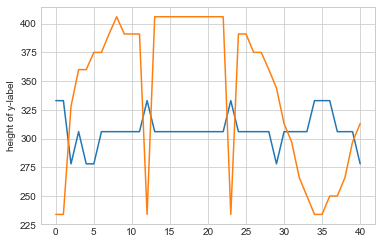

In [277]:
plt.style.use('seaborn-whitegrid')
fig2 = plt.figure()
plt.plot(y)
plt.ylabel('height of y-label')
plt.show()

In [194]:
backSub = cv2.createBackgroundSubtractorMOG2()
backSub2 = cv2.createBackgroundSubtractorKNN()

In [ ]:
### import signal from scipy for SavgolFilter
from scipy import signal

### PushUp Counting Function
def countPushUps(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    ## Apply background masking using MOG2 in OpenCV
    fgMask = backSub.apply(frame)
    flow.append(fgMask)

    ## Calculate centroids for background mask
    centroidsx = []
    centroidsy = []
    centroids = []
    for index in range(len(flow)):
        # convert the grayscale image to binary image
        ret,thresh = cv2.threshold(flow[index],127,255,0)

        M = cv2.moments(thresh)

        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroidsx.append(cX)
        centroidsy.append(cY)
        centroids.append([cX, cY])
        index += 1
        
    ## Smoothing of Signal using Savgol Filter
    smooth_cent = signal.savgol_filter(centroidsy, 41, 3)
    
    ## Calculate gradients for counting
    gradients = []

    for index in range(len(smooth_cent)):
        if index == (len(smooth_cent)-1):
            break
        else:
            dydx = (smooth_cent[index+1]- smooth_cent[index])
            gradients.append(dydx)

    ## Counting of Pushups
    count = 0

    for index in range(len(smooth_cent)):
        if index == (len(smooth_cent)-2):
            break
        if gradient_post[index-1] > 0 and gradient_post[index] <0:
            count += 0.5
        elif gradient_post[index-1] < 0 and gradient_post[index] > 0:
            count += 0.5
        else:
            count = count

    count = int(count)

    return count

In [358]:
cap = cv2.VideoCapture("data/PushUps/PushUps (1).mp4")
#cap = cv2.VideoCapture("data/images/PushUps(1).mp4_frame0.jpg")
flow = []

frameRate = cap.get(5) #frame rate
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    
    if (ret != True):
        break
    if (frameId % 2 == 0):
        # Convert the frame to gray scale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        #update the background model
        fgMask = backSub.apply(frame)
        flow.append(fgMask)

        # Calculate the background
        cv2.imshow('Frame', frame)
        cv2.imshow('FG Mask', fgMask)
        
        if cv2.waitKey(1) & 0x000000FF== 27:    
            break

cap.release()
cv2.destroyAllWindows()

In [359]:
len(flow)
print(flow)

[array([[127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127],
       ...,
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127],
       [127, 127, 127, ..., 127, 127, 127]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..

       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]


In [361]:
centroidsx = []
centroidsy = []
centroids = []
for index in range(len(flow)):
    # convert the grayscale image to binary image
    ret,thresh = cv2.threshold(flow[index],127,255,0)

    M = cv2.moments(thresh)

    # calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroidsx.append(cX)
    centroidsy.append(cY)
    centroids.append([cX, cY])
    index += 1
    
    
    # put text and highlight the center
    #cv2.circle(testimg[20], (cX, cY), 5, (255, 255, 255), -1)
    #cv2.putText(testimg[20], "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    
    
    
    # display the image
    #cv2.imshow("Image", testimg[20])
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

ZeroDivisionError: float division by zero

In [321]:
len(centroids)

150

In [311]:
gradient = []
count = 0

for index in range(len(centroidsy)):
    if index == 149:
        break
    else:
        gradientcal = (centroidsy[index+1]- centroidsy[index])
        if gradientcal == 0 and centroidsy[index] > 350:
            count += 1
            if gradientcal == 0 and centroidsy[index] < 300:
                count /= 2
        gradient.append(centroidsy[index+1]- centroidsy[index])
            
print(count)

3


In [296]:
print(gradient)

[-9, -13, -1, 23, 50, 42, 22, 17, 14, 14, 4, -1, -5, 12, -8, -11, -10, -9, 4, 1, 6, 16, -8, -17, 66, 11, 47, -41, -11, 0, -4, 6, -1, -5, -13, -16, -17, -17, -19, -15, 1, -12, 2, 11, 7, -3, 1, -2, -2, 2, 1, -2, -11, 13, 19, 18, 16, 18, 12, 5, -1, -14, 1, 23, 4, 1, 1, -2, 0, 0, 1, -1, -2, -18, -44, 34, 10, 2, -11, -16, -18, -17, -21, -19, 0, -10, 1, 0, 4, 5, -1, 1, -3, -7, 14, 19, 17, 13, 14, 8, -8, -27, -35, 29, 43, 8, -1, -7, -6, -4, -2, 1, -1, -2, -7, -23, -32, 10, 18, 17, -5, 3, -8, -13, -20, -32, -35, 9, 6, 0, -6, -3, -3, -2, -2, -1, -2, 1, 25, 33, 22, 16, 10, 5, -15, -34, 46, 50, 14]


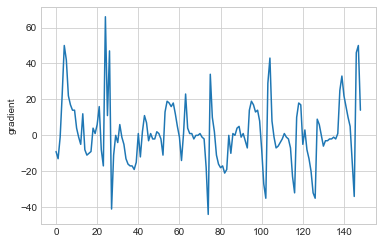

In [297]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.plot(gradient)
plt.ylabel('gradient')
plt.show()

In [331]:
from scipy import signal

smooth_cent = signal.savgol_filter(centroidsy, 41, 3)
print(smooth_cent)


[158.45257125 174.80266812 190.48304985 205.49609156 219.84416837
 233.52965541 246.55492779 258.92236063 270.63432907 281.69320822
 292.10137319 301.86119912 310.97506112 319.44533432 327.27439383
 334.46461478 341.01837229 346.93804148 352.22599747 356.88461538
 360.91627034 365.84013264 369.18377765 370.09712466 368.63506261
 365.95069593 363.70081592 361.82010559 359.95636808 358.08429687
 356.09537938 354.18076705 352.18024347 350.22029757 347.28090231
 343.96182207 339.76460579 334.72564248 328.86059601 322.45839696
 316.28173131 310.45377198 305.57458877 301.48252542 296.61638815
 291.32828657 288.99079366 287.92735285 289.82691217 291.4151141
 293.56568786 296.59932807 300.42148436 305.42816004 311.88263013
 320.29700249 327.40451154 334.04816964 340.38339369 346.6797417
 352.74667307 358.48038745 364.19459837 369.32758846 374.08996902
 378.08861643 381.58667481 383.80287098 384.92896723 384.73340896
 383.21178935 380.75701383 377.28037873 372.8135608  367.07840656
 360.2325581

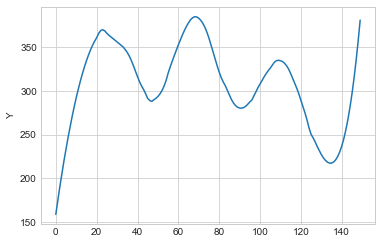

In [332]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.plot(smooth_cent)
plt.ylabel('Y')
plt.show()

In [342]:
gradient_post = []

for index in range(len(smooth_cent)):
    if index == (len(smooth_cent)-1):
        break
    else:
        gradientcal = (smooth_cent[index+1]- smooth_cent[index])
        gradient_post.append(gradientcal)
            
print(len(gradient_post))

149


In [343]:
print(gradient_post)

[16.35009686853138, 15.680381728311403, 15.013041709462328, 14.348076811984015, 13.685487035876633, 13.025272381140098, 12.367432847774353, 11.711968435779568, 11.058879145155515, 10.408164975902423, 9.759825928020064, 9.113862001508664, 8.470273196368112, 7.829059512598292, 7.190220950199489, 6.553757509171362, 5.919669189514252, 5.287955991227932, 4.658617914312458, 4.031654958789886, 4.923862297657308, 3.3436450106899542, 0.913347004668708, -1.462062044591903, -2.6843666826651997, -2.2498800122170337, -1.8807103276758994, -1.8637375103626823, -1.8720712072952779, -1.9889174920373875, -1.914612330380976, -2.000523583053507, -1.9599458964179917, -2.939395261573452, -3.3190802391031866, -4.1972162834331925, -5.03896330555466, -5.865046467996365, -6.402199048824514, -6.176665648588823, -5.827959335049911, -4.87918321043702, -4.092063353549747, -4.866137266024111, -5.288101575112648, -2.3374929098129655, -1.063440813299053, 1.899559317596868, 1.5882019285310207, 2.1505737597627785, 3.033

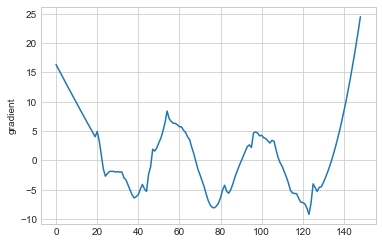

In [338]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.plot(gradient_post)
plt.ylabel('gradient')
plt.show()

In [353]:
count = 0

for index in range(len(smooth_cent)):
    if index == (len(smooth_cent)-2):
        break
    if gradient_post[index-1] > 0 and gradient_post[index] <0:
        count += 0.5
    elif gradient_post[index-1] < 0 and gradient_post[index] > 0:
        count += 0.5
    else:
        count = count
        
count = int(count)
                
print(count)

3


In [101]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

import math
 
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang
 

In [106]:

A = points[0][1]
B = points[0][6]
C = points[0][7]

print(getAngle(A,B,C))


D = points[21][1]
E = points[21][6]
F = points[21][7]

print(getAngle(D,E,F))


G = points[39][1]
H = points[39][6]
I = points[39][7]

print(getAngle(G,H,I))

170.2420365586522
254.05460409907712
206.00725175353213


In [97]:
print(anglefirst)
print(anglesecond)

[343.1428593188522]
[352.2181681425491]


In [189]:
imgindex = 0
angles = []
flip = -1
for index in range(len(testout)):
    A = points[imgindex][7]
    B = points[imgindex][6]
    C = points[imgindex][1]
    
    try:
        if getAngle(A,B,C) != 180.0:
            if angles == []:
                angles.append(getAngle(A,B,C))
            elif getAngle(A,B,C) > angles[flip]:
                angles.append(getAngle(A,B,C))
            else:
                if getAngle(A,B,C) < angles[flip]:
                    angles.append(getAngle(A,B,C))
                    
    except:
        print("Angle is bad")
    print(getAngle(A,B,C))
    
    imgindex += 1
    

    #print(angle_between(B, A))
    # shoulder and hip

    #print(angle_between(B, C))
    # hip and knee

    #print(angle_between(C, D))
    # knee and ankle

189.7579634413478
190.84030545433058
137.40908137447227
147.7849262945233
169.8244891569568
169.88795968908738
180.0
137.91083782616775
119.7448812969422
119.7448812969422
119.7448812969422
119.7448812969422
189.7579634413478
105.94539590092288
105.94539590092288
105.94539590092288
105.94539590092288
105.94539590092288
105.94539590092288
105.94539590092288
105.94539590092288
105.94539590092288
119.7448812969422
190.84030545433058
119.7448812969422
119.7448812969422
119.7448812969422
180.0
144.27901823716712
137.15701350664762
151.78549934961833
154.02049990070714
155.62273359613624
155.62273359613624
190.84030545433058
190.84030545433058
169.15969454566942
158.0534033567203
156.97106134373757
153.99274824646787
133.97095141366546


In [182]:
print(flip)
print(len(angles))
print(angles)

-1
21
[169.15969454566942, 166.08750532347997, 103.79086689736098, 199.0934920004856, 118.17859010995915, 90.0, 167.81136679806812, 239.34933204294714, 196.02586744844976, 19.42082095246683, 196.02586744844976, 193.91249467652, 193.79086689736098, 282.1886332019319, 220.15599962491933, 239.34933204294714, 253.26182671946714, 193.91249467652, 196.02586744844976, 283.91249467652, 76.28098615150752]


In [153]:
imgindex = 0
angles = []
flip = -1
for index in range(len(testout)):
    A = points[imgindex][7]
    B = points[imgindex][13]
    C = points[imgindex][1]
    
    try:
        if getAngle(A,B,C) != 180.0:
            if angles == []:
                angles.append(getAngle(A,B,C))
            elif getAngle(A,B,C) > angles[flip]:
                angles.append(getAngle(A,B,C))
            else:
                if getAngle(A,B,C) < angles[flip]:
                    angles.append(getAngle(A,B,C))
                    
    except:
        print("Angle is bad")
    print(getAngle(A,B,C))
    
    imgindex += 1

21.28887227341346
20.116977115439454
15.815438455250103
14.13855651742142
14.012868917869923
14.086750067629168
12.997203911884014
12.539010746144015
11.394773151666527
12.539010746144015
12.996427999258401
12.996427999258401
21.28887227341346
11.394773151666527
11.009241735235014
11.009241735235014
11.009241735235014
11.394773151666527
11.009241735235014
11.009241735235014
11.009241735235014
11.009241735235014
11.394773151666527
21.28887227341346
12.539010746144015
12.539010746144015
13.758503366685886
14.17161960506894
14.13855651742142
15.184007732384316
16.58344785918581
17.782402803723812
19.60984868449094
19.583603947449888
21.28887227341346
20.116977115439454
21.284219943049663
21.258941900625246
20.083930988435895
18.459259743944415
16.945149901872355


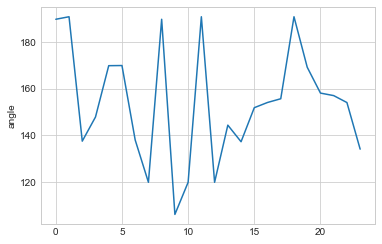

In [190]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.plot(angles)
plt.ylabel('angle')
plt.show()

In [299]:
imgindex = 0
counter = 0
combined = []
for index in range(len(testout)):
    A = points[imgindex][7]
    B = points[imgindex][6]
    C = points[imgindex][1]
    start = getAngle(A,B,C) #straight arms
    
    D = points[imgindex][7]
    E = points[imgindex][13]
    F = points[imgindex][1]
    end = getAngle(D,E,F) #legs parallel to wrist
    
    imgindex +=1
    check = start + end
    combined.append(check)
    print(start+end)

211.04683571476127
210.95728256977003
153.22451982972237
161.92348281194472
183.8373580748267
183.97470975671655
192.99720391188401
150.44984857231177
131.13965444860872
132.2838920430862
132.7413092962006
132.7413092962006
211.04683571476127
117.3401690525894
116.95463763615788
116.95463763615788
116.95463763615788
117.3401690525894
116.95463763615788
116.95463763615788
116.95463763615788
116.95463763615788
131.13965444860872
212.12917772774404
132.2838920430862
132.2838920430862
133.50338466362808
194.17161960506894
158.41757475458854
152.34102123903193
168.36894720880414
171.80290270443095
175.23258228062718
175.20633754358613
212.12917772774404
210.95728256977003
190.4439144887191
179.31234525734556
177.05499233217347
172.45200799041228
150.91610131553782


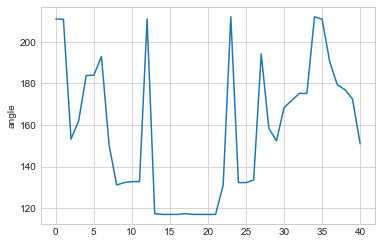

In [300]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.plot(combined)
plt.ylabel('angle')
plt.show()

In [20]:
poseModel = op.PoseModel.BODY_25
print(op.getPoseBodyPartMapping(net))
#print(op.getPoseNumberBodyParts(poseModel))
#print(op.getPosePartPairs(poseModel))
#print(op.getPoseMapIndex(poseModel))

NameError: name 'op' is not defined

In [18]:
import json
#Get the file name for the new file to write
netoutlist = np.array(netout).tolist()
json_string = json.dumps(netoutlist)
datastore = json.loads(json_string)

# If the file name exists, write a JSON string into the file.
if filename:
    # Writing JSON data
    with open('/netout.json', 'w') as f:
        json.dump(datastore, f)

F:\Anaconda3\envs\srsdv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


### Training Model